#### TEXT-TO-SPEECH WITH TACOTRON2

The text-to-speech pipeline

1. Text preprocessing
* Text is encoded into a list of symbols


2. Spectrogram generation
* TacoTron2 model is used to generate a spectrogram from the encoded text

3. Time-domain conversion
* The spectrogram is then converted into a waveform. This process is called a `Vocoder`.

In [1]:
import IPython
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import torch
import torchaudio
device = "cuda" if torch.cuda.is_available() else "cpu"
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8] # Set default figsize

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.0.1+cu118
2.0.2+cu118
cuda


#### Text Processing

The pre-trained Tacotron2 model expects specific set of symbol tables.

##### 1. Character Based Encoding

* First map each character of the input text into the index of the corresponding symbol in the table.

* The set of symbols are: `_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz`


In [3]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

In [4]:
text = "Hello world! Text to speech!"
print(text_to_sequence(text)) # Converts the text into a sequence

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [5]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [6]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


##### 2. Phoneme-based encoding

Similar to `Character based encoding`, but it uses a symbol table based on phonemes and a G2P (Grapheme-to-Phoneme) model.

In [7]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


In [8]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


#### Spectrogram Generation

TacoTron2 is used to generate the spectogram.

`torchaudio.pipelines.Tacotron2TTSBundle` bundles the matching models and processors together

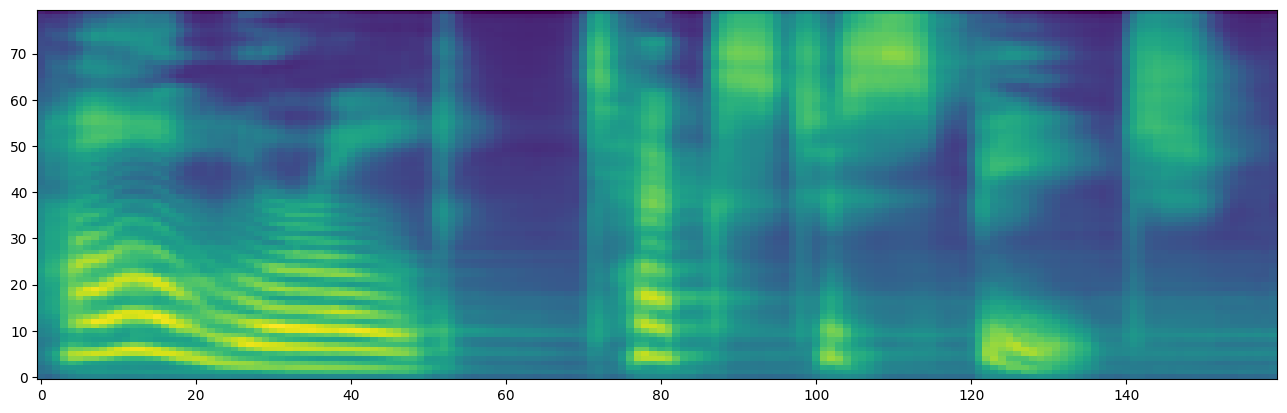

In [9]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 197])
torch.Size([80, 173])
torch.Size([80, 172])


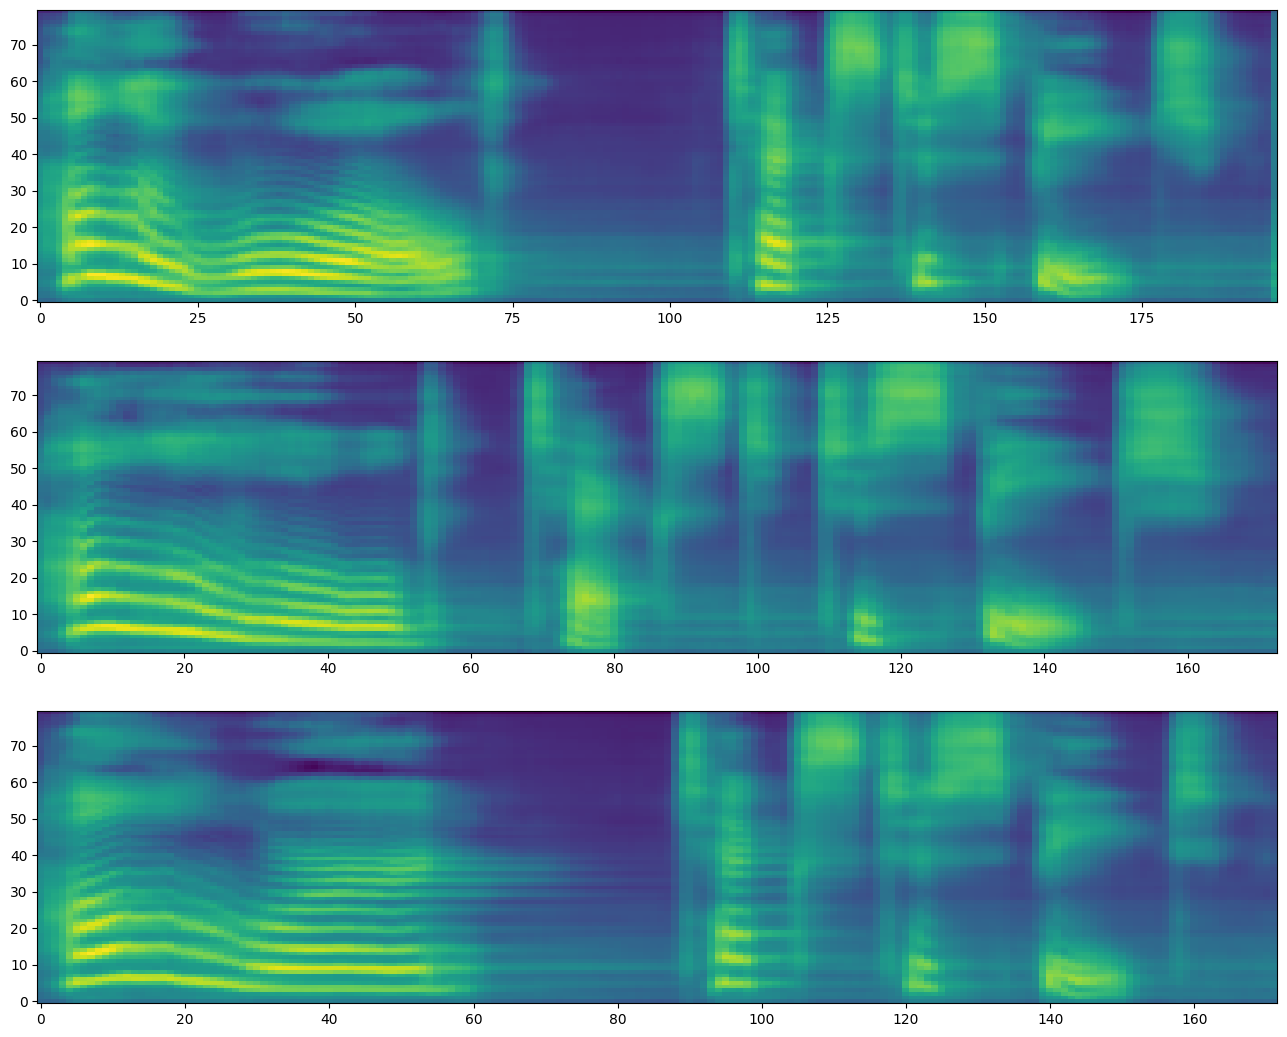

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(16, 4.3 * 3))
for i in range(3):
    with torch.inference_mode():
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    print(spec[0].shape)
    ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
plt.show()

#### Waveform Generation
The last process is to get the waveform from the spectrogram.

`torchaudio` provides vocoders based on `GriffinLim` and `WaveRNN`.

1. WaveRNN

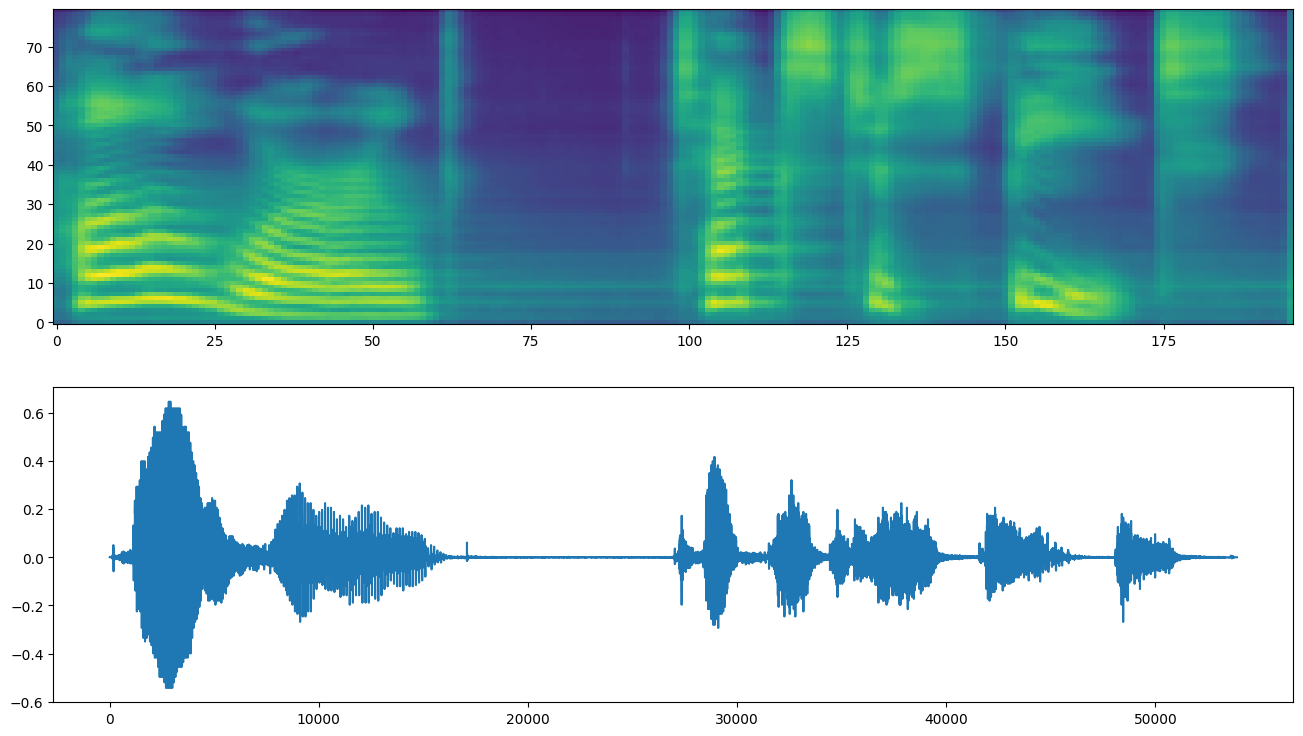

In [11]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

2. Griffin-Lim


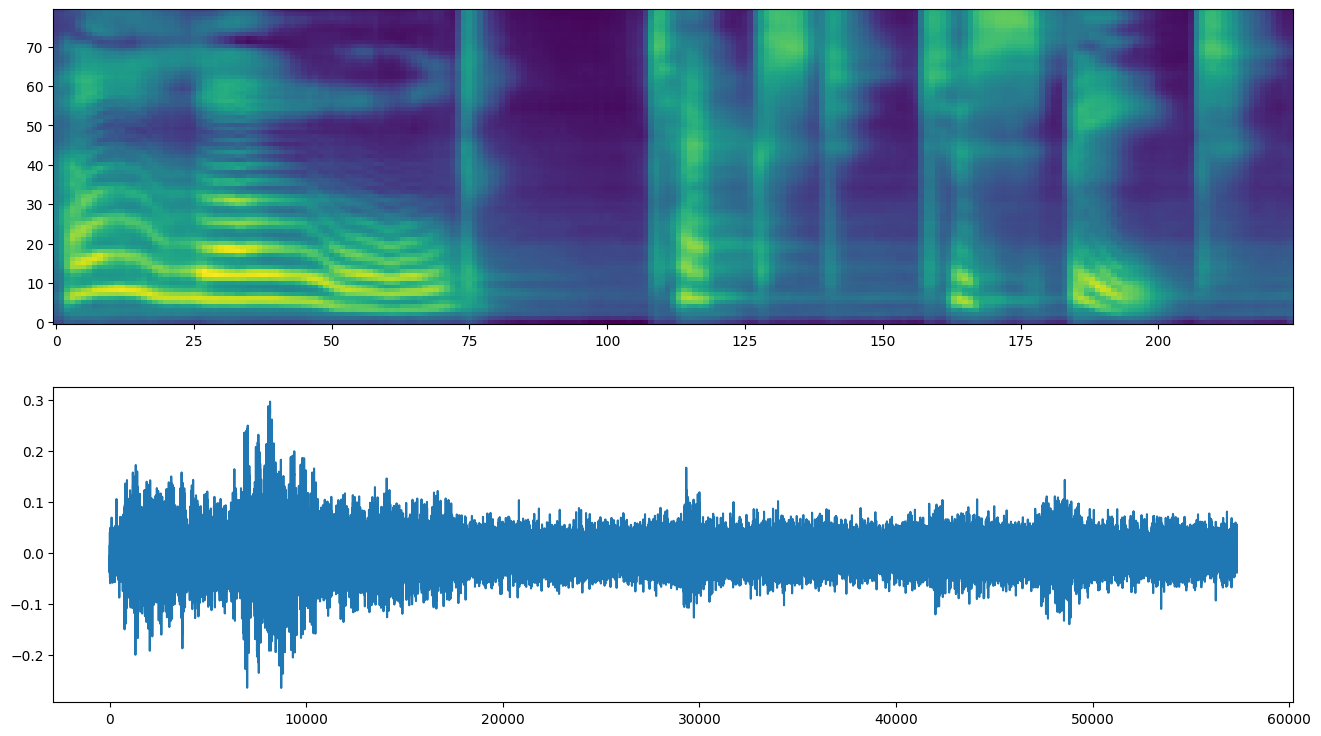

In [12]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

3. Waveglow

Waveglow is a vocoder published by Nvidia

Using cache found in C:\Users\jack6/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\jack6/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\jack6/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


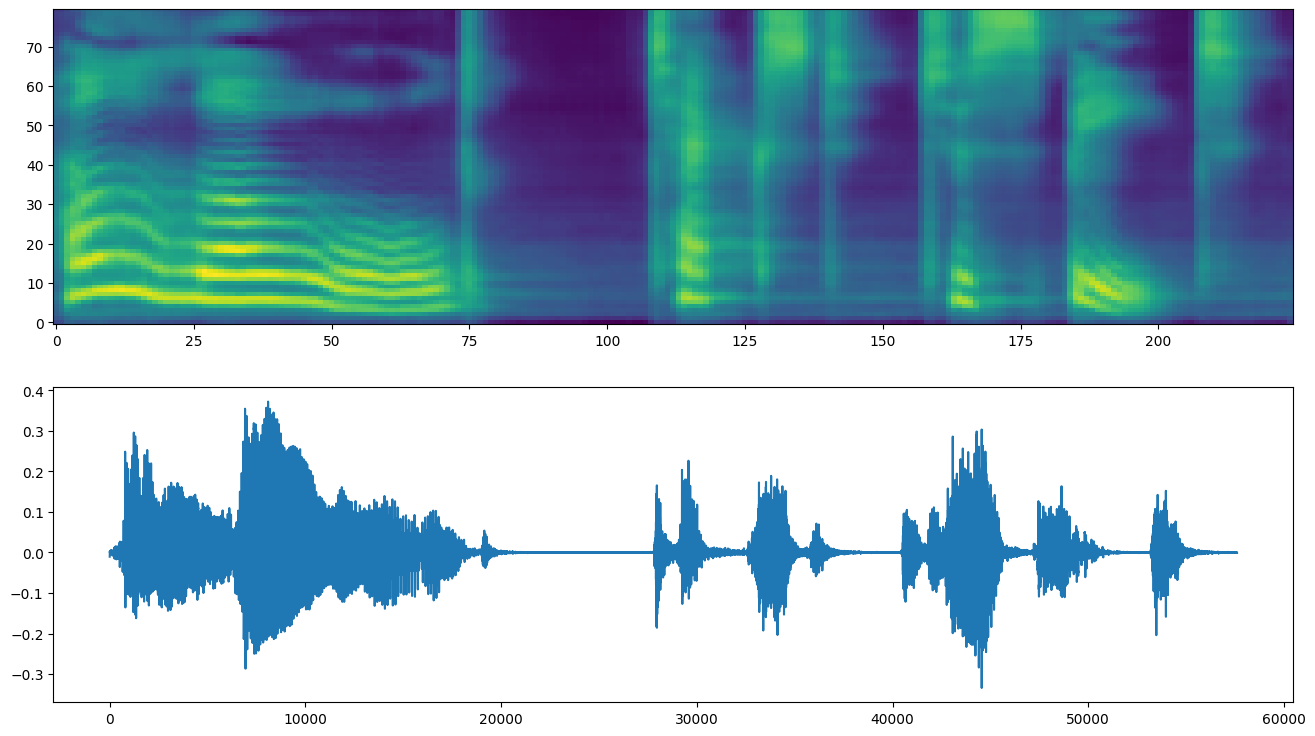

In [13]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=22050)